<a href="https://colab.research.google.com/github/mpradiptanugroho2020-ops/221230031-Pengantar-ML/blob/main/project_week/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import Library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 2. Konfigurasi Path & Parameter
DATASET_PATH = r"C:\Users\User\Documents\Analitik_Data\UAS_ML\seg_train\seg_train"
IMG_SIZE = (32, 32)
BATCH_SIZE = 16
SEED = 42


classes = sorted(os.listdir(DATASET_PATH))
print("Classes:", classes)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


       Class  Count
0  buildings   2191
1     forest   2271
2    glacier   2404
3   mountain   2512
4        sea   2274
5     street   2382


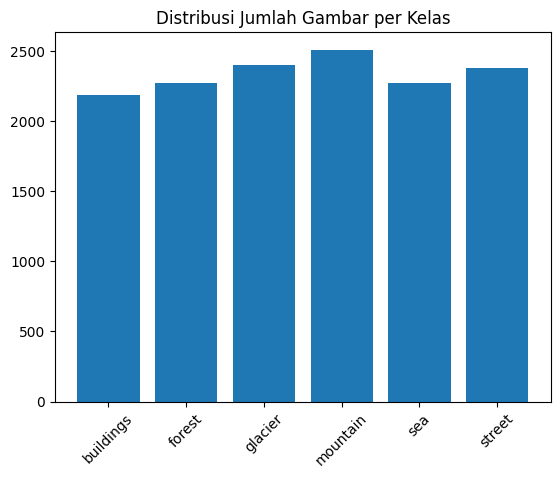

In [ ]:
# 3. EDA

data_count = {}

for cls in classes:
    data_count[cls] = len(os.listdir(os.path.join(DATASET_PATH, cls)))


eda_df = pd.DataFrame(list(data_count.items()), columns=["Class", "Count"])
print(eda_df)


plt.figure()
plt.bar(eda_df['Class'], eda_df['Count'])
plt.xticks(rotation=45)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.show()

In [ ]:
# 4. Load Data untuk Traditional ML

def load_images_flatten(path, img_size):
    X, y = [], []

    for label, cls in enumerate(classes):
        cls_path = os.path.join(path, cls)

        for file in os.listdir(cls_path):
            img = Image.open(os.path.join(cls_path, file)).convert('RGB')
            img = img.resize(img_size)
            X.append(np.array(img).flatten() / 255.0)
            y.append(label)

    return np.array(X), np.array(y)


X, y = load_images_flatten(DATASET_PATH, IMG_SIZE)


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [ ]:
# 5. Random Forest Model

rf = RandomForestClassifier(
n_estimators=100,
max_depth=15,
random_state=SEED,
n_jobs=-1
)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest:", acc_rf)

Accuracy Random Forest: 0.6017100106875668


In [ ]:
# 6. MLP Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


mlp = MLPClassifier(
hidden_layer_sizes=(256, 128),
activation='relu',
solver='adam',
max_iter=30,
random_state=SEED
)


mlp.fit(X_train_scaled, y_train)


y_pred_mlp = mlp.predict(X_test_scaled)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy MLP:", acc_mlp)

c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy MLP: 0.6205913786961168


In [ ]:
# 7. Data Generator untuk CNN

datagen = ImageDataGenerator(
rescale=1./255,
validation_split=0.2
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(32,32),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(32,32),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
# 8. CNN Model

cnn = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

cnn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
)


c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - accuracy: 0.5641 - loss: 1.1925 - val_accuracy: 0.4354 - val_loss: 1.8675
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.6456 - loss: 0.9423 - val_accuracy: 0.6872 - val_loss: 0.8363
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.6767 - loss: 0.8604 - val_accuracy: 0.7193 - val_loss: 0.7462
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.7054 - loss: 0.7930 - val_accuracy: 0.7447 - val_loss: 0.6818
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.7229 - loss: 0.7557 - val_accuracy: 0.7500 - val_loss: 0.6822
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.7438 - loss: 0.7145 - val_accuracy: 0.7454 - val_loss: 0.7416
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.7462 - loss: 0.6881 - val_accuracy: 0.7832 - val_loss: 0.6044
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.7593 - loss: 0

In [ ]:
# 9. Evaluasi CNN
val_gen.reset()
pred = cnn.predict(val_gen)
y_pred_cnn = np.argmax(pred, axis=1)
y_true_cnn = val_gen.classes

acc_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
print("Accuracy CNN:", acc_cnn)

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
Accuracy CNN: 0.8323823109843081


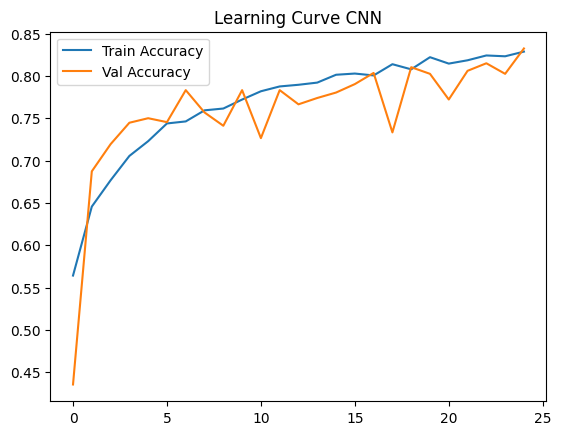

In [ ]:
# 10. Learning Curve CNN

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Learning Curve CNN')
plt.show()

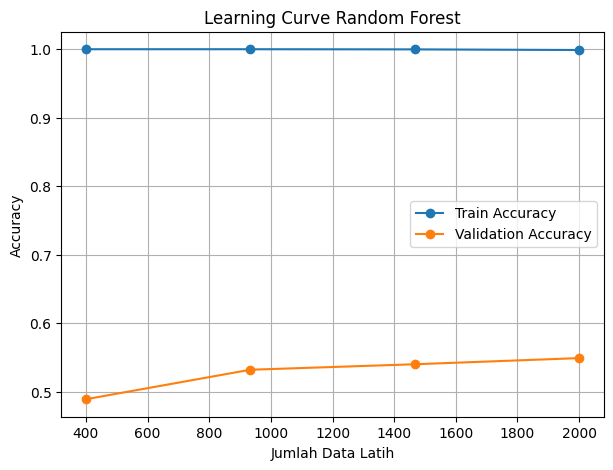

In [ ]:
# 12. Learning Curve RF

MAX_SAMPLES = 3000

if len(X_train) > MAX_SAMPLES:
    idx = np.random.choice(len(X_train), MAX_SAMPLES, replace=False)
    X_lc_rf = X_train[idx]
    y_lc_rf = y_train[idx]
else:
    X_lc_rf = X_train
    y_lc_rf = y_train

train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    rf,
    X_lc_rf,
    y_lc_rf,
    train_sizes=np.linspace(0.2, 1.0, 4),
    cv=3,
    scoring='accuracy',
    n_jobs=1
)


plt.figure(figsize=(7,5))
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes_rf, val_scores_rf.mean(axis=1), 'o-', label='Validation Accuracy')
plt.title('Learning Curve Random Forest')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\Documents\Analitik_Data\UAS_ML\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't conv

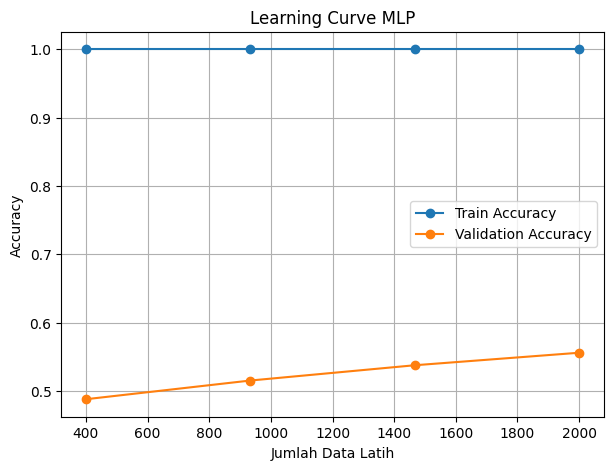

In [ ]:
# 13. Learning Curve MLP

if len(X_train_scaled) > MAX_SAMPLES:
    idx = np.random.choice(len(X_train_scaled), MAX_SAMPLES, replace=False)
    X_lc_mlp = X_train_scaled[idx]
    y_lc_mlp = y_train[idx]
else:
    X_lc_mlp = X_train_scaled
    y_lc_mlp = y_train


train_sizes_mlp, train_scores_mlp, val_scores_mlp = learning_curve(
    mlp,                     #
    X_lc_mlp,
    y_lc_mlp,
    train_sizes=np.linspace(0.2, 1.0, 4),
    cv=3,
    scoring='accuracy',
    n_jobs=1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes_mlp, train_scores_mlp.mean(axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes_mlp, val_scores_mlp.mean(axis=1), 'o-', label='Validation Accuracy')
plt.title('Learning Curve MLP')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# 14. Tabel Perbandingan Akurasi

import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'MLP', 'CNN'],
    'Accuracy': [acc_rf, acc_mlp, acc_cnn]
})

# Ubah ke persen
comparison_df['Accuracy (%)'] = (comparison_df['Accuracy'] * 100).round(2)

# Hapus kolom desimal jika tidak perlu
comparison_df = comparison_df[['Model', 'Accuracy (%)']]

print(comparison_df)



           Model  Accuracy (%)
0  Random Forest         60.17
1            MLP         62.06
2            CNN         83.24


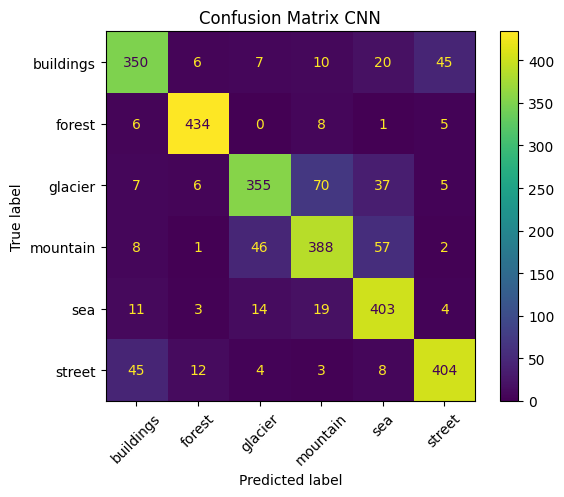

In [ ]:
# 15. Confusion Matrix (Model Terbaik: CNN)

cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix CNN")
plt.show()